<a href="https://colab.research.google.com/github/kjquisper/Calculadora/blob/main/Copia_de_04_Classifier_Free_Diffusion_IA_ESIS_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Guia de Difusión sin Clasificador

In [1]:
!wget https://github.com/ichaparroc/IA-ESIS-UNJBG/raw/main/GenAI.zip
!unzip GenAI.zip

--2024-07-16 10:02:03--  https://github.com/ichaparroc/IA-ESIS-UNJBG/raw/main/GenAI.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichaparroc/IA-ESIS-UNJBG/main/GenAI.zip [following]
--2024-07-16 10:02:03--  https://raw.githubusercontent.com/ichaparroc/IA-ESIS-UNJBG/main/GenAI.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24221606 (23M) [application/zip]
Saving to: ‘GenAI.zip’

GenAI.zip           100%[===================>]  23.10M  --.-KB/s    in 0.1s    

2024-07-16 10:02:05 (189 MB/s) - ‘GenAI.zip’ saved [24221606/24221606]

Archive:  GenAI.zip
   creating: images/
  inflating:

Hasta ahora, hemos podido entrenar un modelo para generar imágenes de ropa utilizando el conjunto de datos [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Sin embargo, no hay forma de que el usuario especifique qué tipo de imágenes deben generarse. Vamos a solucionarlo creando un [Modelo de difusión condicional](https://github.com/TeaPearce/Conditional_Diffusion_MNIST/tree/main). Más tarde mejoraremos el rendimiento utilizando [Classifier-Free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf).

#### Objetivos de aprendizaje

Los objetivos de este cuaderno son:
* Añadir incrustaciones categóricas a una U-Net
* Entrenar un modelo con una máscara Bernoulli
* Añadir un peso al proceso de difusión inversa
* Practicar los aprendizajes en un conjunto de datos más desafiante


Antes de empezar, vamos a cargar las bibliotecas necesarias y la información del conjunto de datos.

In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00


In [3]:
import glob
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 26421880/26421880 [00:07<00:00, 3377962.30it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 167963.83it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1551420.24it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5963070.14it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## 4.1 Entrenamiento del modelo

Nuestro calendario `B`eta de antes seguirá siendo el mismo.

In [5]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

Esta vez, nuestra `UNet` es ligeramente diferente. Hemos añadido algunos cambios y movido la arquitectura U-Net a su propia carpeta [UNet_utils.py](utils/UNet_utils.py).

En la función `__init__`, hemos añadido un nuevo parámetro: `c_embed_dim`. Al igual que para el paso de tiempo `t`, podemos crear una incrustación para nuestras categorías de clase.

```python
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0]) # Nuevo
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1]) # Nuevo
```

A continuación, en la función `forward`, tenemos dos nuevos parámetros: `c` y `c_mask`.
* `c` es un vector que representa nuestra entrada categórica. Puede ser un [one-hot encoding](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding) o un vector de incrustación.
* `c_mask` se utiliza para establecer aleatoriamente los valores dentro de `c` a cero. Esto ayuda al modelo a aprender lo que una salida media podría ser sin una entrada categórica, como en el cuaderno anterior.

```python
        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)
```

Hay muchas formas diferentes de combinar esta información categórica incrustada en el modelo. Un método popular es con [escalado y desplazamiento](https://arxiv.org/pdf/2210.08823.pdf). Podemos escalar (multiplicar) nuestra incrustación categórica a la imagen latente y luego (añadir) nuestra incrustación temporal `t_emb`. La escala y el desplazamiento actúan como una especie de varianza y media respectivamente.

```python
        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2) # Cambiado
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1) # Cambiado
        return self.out(antorcha.cat((up2, down0), 1))
```

Convertiremos nuestra etiqueta a un formato que pueda ser procesado por el modelo utilizando la función `get_context_mask` que aparece a continuación. Dado que nuestra etiqueta es un único número entero, podemos utilizar [F.one_hot](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) para convertirla en un vector de codificación.

Para poner aleatoriamente a cero los valores de esta codificación, podemos utilizar la distribución [Bernoulli](https://mathworld.wolfram.com/BernoulliDistribution.html). Esta distribución es como lanzar una moneda ponderada. "Cara" saldrá $p$ por ciento de las veces y "Cruz" saldrá $1-p$ por ciento de las veces. En este caso, nuestro `drop_prob` representa "Cruz".

In [6]:
def get_context_mask(c, drop_prob):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=N_CLASSES).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

Estos son todos los cambios que necesitamos añadir a nuestra `UNet` para que aprenda de datos categóricos. Vamos a construir una instancia de esta nueva estructura.

In [7]:
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  2002561


Para saber lo que el modelo está intentando generar, no perdamos de vista los diferentes nombres de las clases. El orden aquí coincide con el orden de las etiquetas del conjunto de datos. Por ejemplo, cuando la etiqueta es 3, representa un vestido.

In [8]:
class_names = [
    "Top", #top
    "Trouser", #pantalon
    "Pullover", #jersey (chompa)
    "Dress", #vestido
    "Coat", #abrigo
    "Sandal", #sandalia
    "Shirt", #camisa
    "Sneaker", #zapatilla
    "Bag", #bolso
    "Ankle boot", #botin
]

Nuestro paso de entrenamiento es casi el mismo que la última vez. Haremos un ciclo a través de cada clase en cada paso de vista previa para que podamos ver cómo el modelo aprende a través de todas las clases.

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 | Step 000 | Loss: 1.062807559967041 | C: Top


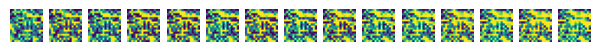

Epoch 0 | Step 100 | Loss: 0.15731777250766754 | C: Trouser


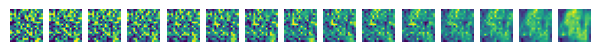

Epoch 0 | Step 200 | Loss: 0.1322292536497116 | C: Pullover


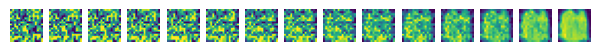

Epoch 0 | Step 300 | Loss: 0.10840479284524918 | C: Dress


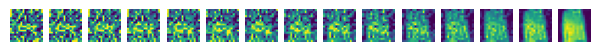

Epoch 0 | Step 400 | Loss: 0.14049386978149414 | C: Coat


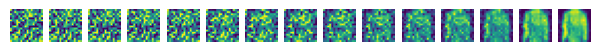

Epoch 0 | Step 500 | Loss: 0.12010589241981506 | C: Sandal


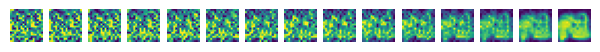

Epoch 1 | Step 000 | Loss: 0.12094853818416595 | C: Shirt


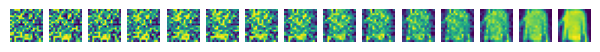

Epoch 1 | Step 100 | Loss: 0.10357169806957245 | C: Sneaker


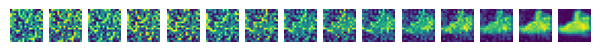

Epoch 1 | Step 200 | Loss: 0.10983364284038544 | C: Bag


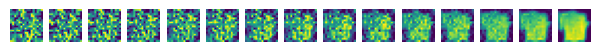

Epoch 1 | Step 300 | Loss: 0.12439132481813431 | C: Ankle boot


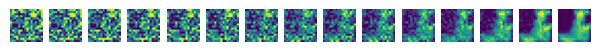

Epoch 1 | Step 400 | Loss: 0.1023179441690445 | C: Top


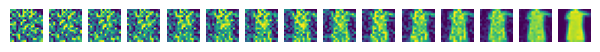

Epoch 1 | Step 500 | Loss: 0.09776764363050461 | C: Trouser


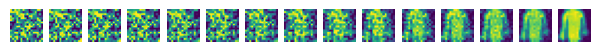

Epoch 2 | Step 000 | Loss: 0.08752854913473129 | C: Pullover


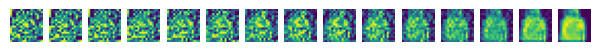

Epoch 2 | Step 100 | Loss: 0.10435153543949127 | C: Dress


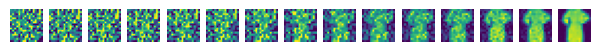

Epoch 2 | Step 200 | Loss: 0.10163721442222595 | C: Coat


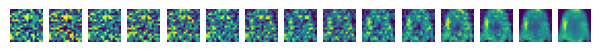

Epoch 2 | Step 300 | Loss: 0.10136789083480835 | C: Sandal


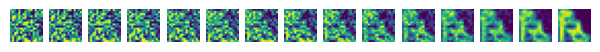

Epoch 2 | Step 400 | Loss: 0.08904770016670227 | C: Shirt


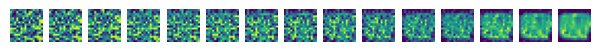

Epoch 2 | Step 500 | Loss: 0.09052197635173798 | C: Sneaker


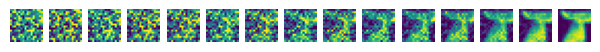

In [9]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
preview_c = 0

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)  # New
        loss = ddpm.get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            class_name = class_names[preview_c]
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {class_name}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob)
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES

¿Cómo lo ha hecho? Intenta ejecutar la celda de código siguiente para ver el resultado final de cada clase.

Top


<Figure size 800x800 with 0 Axes>

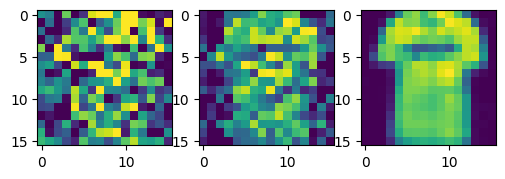

Trouser


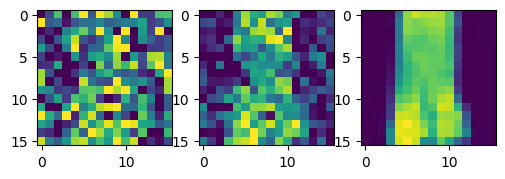

Pullover


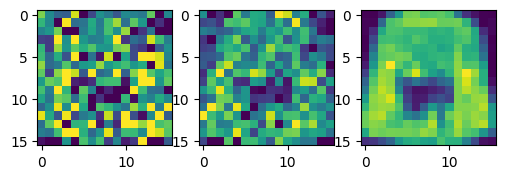

Dress


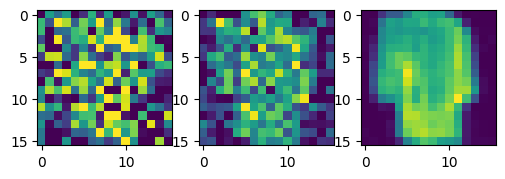

Coat


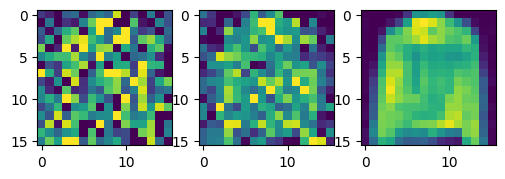

Sandal


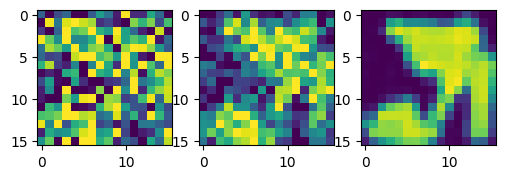

Shirt


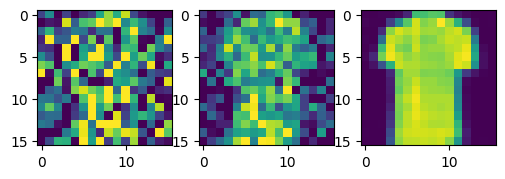

Sneaker


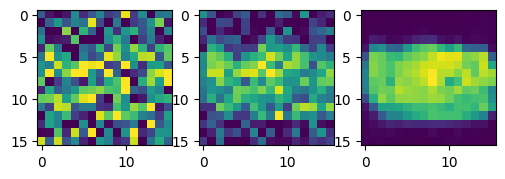

Bag


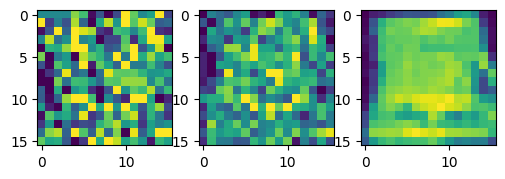

Ankle boot


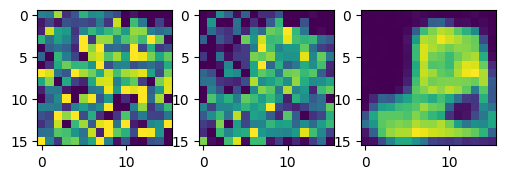

In [10]:
plt.figure(figsize=(8,8))
ncols = 3
c_drop_prob = 0 # Change me to a value between 1 and 0

for c in range(10):
    print(class_names[c])
    c_hot, c_mask = get_context_mask(torch.Tensor([c]), c_drop_prob)
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask, axis_on=True)

# Pregunta 1
Describe cualitativamente los resultados, logras reconocer las clases? Algún resultado parece combinar 2 clases?

se puede distinguir la clase "top" sin embargo parece estar combinado con la clase "shirt" asimilandose mas a esa, en la clase "trouser" se observa que no esta bien definida la division de las piernas, asi que posiblemente este conbinado con otra clase ,en la clase "Pullover" se puede distinguir las mangas y la parte inferior claramente, en la clase "Dress" al parecer es un resultado combinado con la clase "shirt" ya que se puede reconocer mas indicios de esa clase , en la clae "coat" se observa una ligera similitud con la clase "shirt" ,en la clase "sandal" se muestra una imagen definida en la parte de la plante , sin embargo tambien se asemejea a la clase "Ankle boot" ,en la clase "shir" se observa ina imagen clara y definida, en la clase "Sneaker" al parecer se observa a muy grandes rasgos la similitud que tiene , en la clase " Bag" se puede reconocer de manera ligera una mochila con sus 2 tirantes , y en la clase "Ankle boot" si bien no se reconoce del todo unos botines hay caracteristicas que si son claras con el taco , la planta y la parte de empeine



## 4.2 Condicionando la difusión inversa

No está mal, pero tampoco es genial. Algunas de las clases siguen influyéndose mutuamente. Por ejemplo, podrías encontrar un zapato que parece tener una manga de camisa colgando de él.

Podemos arreglar esto aumentando el "peso" de la categoría. Esta es la estrategia:
* Durante el proceso de difusión inversa en cada paso de tiempo, vamos a eliminar el ruido de la imagen **dos veces**.
  * La primera imagen de ruido que extraigamos **conservará** la información del clasificador (`e_t_keep_c`).
  * La segunda imagen de ruido que extraigamos **suprimirá** la información de su clasificador (`e_t_drop_c`)
* Restaremos el ruido medio del ruido categórico usando:
  * `e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c`
  * donde "w" es un valor de peso que elegimos como hiperparámetro.
* Usaremos este nuevo ruido `e_t` para realizar la difusión con `reverse_q`.
* Repetir los pasos anteriores desde `t` = `T` hasta `0`.

<center><img src="images/weighted_reverse_diffusion.png"/></center>

Hemos definido estos pasos en `sample_w` a continuación. `sample_w` toma una lista de pesos de ruido para que podamos comparar cómo afecta a los resultados de difusión.

In [11]:
@torch.no_grad()
def sample_w(
    model, input_size, T, c, w_tests=[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0], store_freq=10
):
    # Preprase "grid of samples" with w for rows and c for columns
    n_samples = len(w_tests) * len(c)

    # One w for each c
    w = torch.tensor(w_tests).float().repeat_interleave(len(c))
    w = w[:, None, None, None].to(device)  # Make w broadcastable
    x_t = torch.randn(n_samples, *input_size).to(device)

    # One c for each w
    c = c.repeat(len(w_tests), 1)

    # Double the batch
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).to(device)
    c_mask[n_samples:] = 0.0

    x_t_store = []
    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Find weighted noise
        e_t = model(x_t, t.float(), c.float(), c_mask.float())
        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = ddpm.reverse_q(x_t, t, e_t)

        # Store values for animation
        if i % store_freq == 0 or i == T or i < 10:
            x_t_store.append(x_t)

    x_t_store = torch.stack(x_t_store)
    return x_t, x_t_store

¡Es hora de verlo en acción! Ejecute el código de abajo generar algunos artículos de ropa y organizarlos en una cuadrícula con [make_grid](https://pytorch.org/vision/main/generated/torchvision.utils.make_grid.html).

In [12]:
c = torch.arange(N_CLASSES).to(device)
c_drop_prob = 0  # Keep all category information for sampling
c_hot, c_mask = get_context_mask(c, c_drop_prob)
input_size = (IMG_CH, IMG_SIZE, IMG_SIZE)

x_0, x_t_store = sample_w(model, input_size, T, c_hot.float())

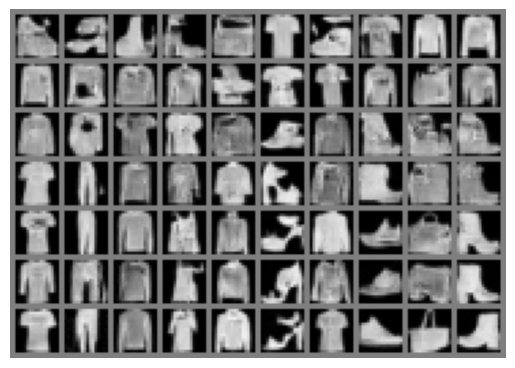

In [13]:
grids = [other_utils.to_image(make_grid(x_t.cpu(), nrow=N_CLASSES)) for x_t in x_t_store]
other_utils.save_animation(grids, "fashionMNIST.gif")

Abra el archivo `fashionMNIST.gif` desde los archivos de Google Colab para ver la animación del proceso de difusión inversa que se acaba de generar.

Las filas representan valores `w` crecientes desde `[-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]`. Las dos primeras filas son negativas, lo que significa que destaca más el valor medio del modelo que el valor categórico. A veces, el modelo genera prendas completamente diferentes de las que se pretendía. Las últimas filas son coherentes al generar artículos que coinciden con su etiqueta.

# Pregunta 2
Explique con sus palabras qué diferencia hay entre asignar a `w` el valor `-2.0` y `2.0`.


la variables 'W'  ajusta el peso relativo de dos tipos de ruido en la imagen: uno que conserva la información del clasificador y otro que la elimina

si 'w' = -2.0 Aquí estamos dando más peso al ruido que suprime la información del clasificador e implica que el modelo tiende a enfatizar más el ruido promedio del modelo y elimina en gran medida la información categórica lo que resulta en las imágenes menos coherentes con la etiqueta original.

si 'w' = 2.0  Aqui estamos dando más peso al ruido que conserva la información del clasificador e implica que el modelo enfatiza más la información categórica y esto resulta en que las imágenes generadas son más coherentes con las etiquetas originales.

## 4.3 Flores TF modificadas

¡Enhorabuena por haber llegado tan lejos! Has dominado FashionMNIST, así que ahora es el momento de un reto mayor: las imágenes en color. Para este reto, utilizaremos una versión modificada del conjunto de datos [TF Flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers).

Estas imágenes se han modificado ligeramente con el fin de generar imágenes centradas en la flor.

El modelo tardará mucho más en entrenarse debido a esta dimensión adicional del color. Para acelerar las cosas, precarguemos las imágenes en la GPU. Si las redimensionamos (https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) antes de cargarlas en la GPU, no ocuparán mucho espacio.

Podemos utilizar esta técnica porque el conjunto de datos es relativamente pequeño. Con un conjunto de datos más grande, esto puede no ser factible.

Para empezar, debemos definir las variables del conjunto de datos:
* Anchura y altura de la imagen `IMG_SIZE`.
* Número de canales de imagen `IMG_CH`.
* Tamaño del lote `BATCH_SIZE`.
* Tamaño de la imagen generada `INPUT_SIZE`.

In [14]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

Para almacenar las imágenes en la GPU, tendremos una lista de `pre_transforms` que se ejecutarán una vez cuando inicialicemos nuestro conjunto de datos. Después, las `random_transforms` se ejecutarán en cada lote cuando se extraiga del conjunto de datos.

[Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) cambiará el tamaño de una imagen para que el borde más pequeño entre la anchura y la altura coincida con el tamaño que especifiquemos. A continuación, podemos utilizar [RandomCrop](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html) para cuadrar la imagen y aumentar efectivamente el tamaño de nuestro conjunto de datos con el aumento aleatorio de datos.

In [15]:
import torchvision
from torch.utils.data import Dataset, DataLoader

pre_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
])

A continuación, vamos a desarrollar una función para leer los archivos de imagen. Utilizaremos directamente el padre de cada imagen para identificar su etiqueta. Tenemos tres categorías listadas en `DATA_LABELS` más abajo.

Utilicemos la función [glob](https://docs.python.org/3/library/glob.html) para obtener mediante programación las rutas de datos de cada foto de flores.

In [16]:
DATA_DIR = "data/cropped_flowers/"
DATA_LABELS = ["daisy", "sunflowers", "roses"]
N_CLASSES = len(DATA_LABELS)

data_paths = glob.glob(DATA_DIR + DATA_LABELS[0] + '/*.jpg', recursive=True)
data_paths[:5]  # First 5 paths

['data/cropped_flowers/daisy/3706420943_66f3214862_n.jpg',
 'data/cropped_flowers/daisy/4646886118_b5c5ceaf6d_n.jpg',
 'data/cropped_flowers/daisy/9054268881_19792c5203_n.jpg',
 'data/cropped_flowers/daisy/14219214466_3ca6104eae_m.jpg',
 'data/cropped_flowers/daisy/450128527_fd35742d44.jpg']

Podemos utilizar las herramientas [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) de pytorch para crear nuestro propio conjunto de datos. `__init__` se ejecutará una vez cuando se inicialice la clase. `__getitem__` devuelve nuestras imágenes y etiquetas aplicando aleatoriamente nuestras `random_transforms`.

In [17]:
class MyDataset(Dataset):
    def __init__(self):
        self.imgs = []
        self.labels = []

        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(DATA_DIR + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_transforms(img).to(device))
                self.labels.append(l_idx)


    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

train_data = MyDataset()
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Es hora de inicializar nuestra U-Net. Es lo mismo que antes, pero nuestro `T` es mucho más grande al igual que nuestro `down_chs`.

In [18]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

In [19]:
model_flowers = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model_flowers.parameters()))
model_flowers = torch.compile(model_flowers.to(device))

Num params:  44509443


Vamos a crear una función para muestrear nuestro modelo de difusión, de forma que podamos generar imágenes durante y después del entrenamiento.

In [20]:
def sample_flowers(n_classes):
    c_test = torch.arange(n_classes).to(device)
    c_hot_test, c_mask_test = get_context_mask(c_test, 0)
    x_gen, x_gen_store = sample_w(model_flowers, INPUT_SIZE, T, c_hot_test)
    return x_gen, x_gen_store

# Ejercicio 3

**TODO** A continuación se muestra nuestro nuevo bucle de entrenamiento. Lo hemos convertido en una función, pero aún no está completo. Cada `FIXME` debe ser reemplazado por uno de los siguientes parámetros de entrada de la función:
* `dataloader`
* `epochs`
* `n_classes`
* `c_drop_prob`

Si es necesario, consulte las funciones implementadas arriba.

In [21]:
def train_flowers(dataloader, epochs=100, n_classes=N_CLASSES, c_drop_prob=0.1, save_dir = "04_images/"):
    lrate = 1e-4
    optimizer = torch.optim.Adam(model_flowers.parameters(), lr=lrate)

    model_flowers.train()
    for epoch in range(epochs):
        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x = batch[0].float().to(device)
            c_hot, c_mask = get_context_mask(batch[1], c_drop_prob)
            loss = ddpm.get_loss(model_flowers, x.float(), t.float(), c_hot.float(), c_mask.float())
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
        if epoch % 5 == 0 or epoch == int(epochs - 1):
            x_gen, x_gen_store = sample_flowers(n_classes)
            grid = make_grid(x_gen.cpu(), nrow=n_classes)
            save_image(grid, save_dir + f"image_ep{epoch:02}.png")
            print("saved images in " + save_dir + f" for episode {epoch}")

El momento de la verdad Veamos cómo maneja el modelo de difusión las imágenes en color. El modelo tardará unos **quince minutos** en entrenarse. Cuando empiece a entrenarse, tómate un café, un té o la bebida que prefieras. A continuación, echa un vistazo a los resultados de la prueba en el directorio `04_images`. Las flores se reconocen a partir de la epoch 50, y el modelo alcanzará su punto álgido a partir de la epoch 100. Es divertido ver cómo aprende. Es divertido ver cómo aprende.

In [22]:
train_flowers(dataloader)

Epoch 0 | Step 008 | Loss: 0.498211145401001
saved images in 04_images/ for episode 0
Epoch 1 | Step 008 | Loss: 0.23525433242321014
Epoch 2 | Step 008 | Loss: 0.1781160682439804
Epoch 3 | Step 008 | Loss: 0.18913798034191132
Epoch 4 | Step 008 | Loss: 0.16658654808998108
Epoch 5 | Step 008 | Loss: 0.14424745738506317
saved images in 04_images/ for episode 5
Epoch 6 | Step 008 | Loss: 0.1805988848209381
Epoch 7 | Step 008 | Loss: 0.14159807562828064
Epoch 8 | Step 008 | Loss: 0.15027526021003723
Epoch 9 | Step 008 | Loss: 0.13056842982769012
Epoch 10 | Step 008 | Loss: 0.15634912252426147
saved images in 04_images/ for episode 10
Epoch 11 | Step 008 | Loss: 0.11561398208141327
Epoch 12 | Step 008 | Loss: 0.12772750854492188
Epoch 13 | Step 008 | Loss: 0.13519367575645447
Epoch 14 | Step 008 | Loss: 0.15681998431682587
Epoch 15 | Step 008 | Loss: 0.11360333859920502
saved images in 04_images/ for episode 15
Epoch 16 | Step 008 | Loss: 0.11411555856466293
Epoch 17 | Step 008 | Loss: 0.10

Debido a la naturaleza aleatoria de los modelos de difusión, algunas imágenes aparecerán mejor que otras. A continuación, ejecute la celda para convertirla en una animación.

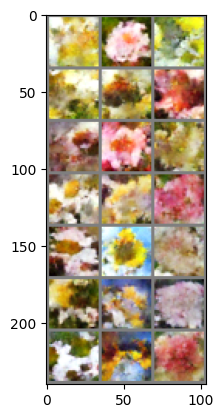

In [23]:
model.eval()
x_gen, x_gen_store = sample_flowers(N_CLASSES)
grid = make_grid(x_gen.cpu(), nrow=N_CLASSES)
other_utils.show_tensor_image([grid])
plt.show()

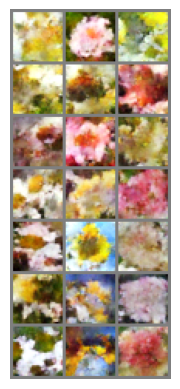

In [24]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=N_CLASSES)) for x_gen in x_gen_store]
other_utils.save_animation(grids, "flowers.gif")

Abra el archivo `flowers.gif` desde los archivos de Google Colab para ver la animación del proceso de difusión inversa que se acaba de generar.